In [1]:
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any, TypedDict, Annotated, Union

import asyncio
import time
import json
from concurrent.futures import ThreadPoolExecutor

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import tool
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages

import nest_asyncio

from IPython.display import Image, SVG, display

Number = Union[int, float]

In [2]:
@tool
def add_numbers(a: Number, b: Number) -> int:
    """Return the sum of two integers."""
    return a + b

# Add these new tools to your existing TOOLS list
@tool
def subtract_numbers(a: Number, b: Number) -> int:
    """Return the difference of two integers (a - b)."""
    return a - b

@tool
def multiply_numbers(a: Number, b: Number) -> int:
    """Return the product of two integers."""
    return a * b

@tool
def divide_numbers(a: Number, b: Number) -> float:
    """Return the division of two integers (a / b)."""
    if b == 0:
        return "Cannot divide by zero"
    return a / b

# Update your TOOLS list
TOOLS = [add_numbers, subtract_numbers, multiply_numbers, divide_numbers]
TOOL_MAP = {t.name: t for t in TOOLS}

# Async tool execution functions
async def execute_tool_async(tool_call: dict, tool_map: dict) -> dict:
    """Execute a single tool call asynchronously."""
    name, args, tc_id = tool_call["name"], tool_call["args"], tool_call["id"]
    
    print(f"🔧 Starting async: {name}({args})")
    start_time = time.time()
    
    if name not in tool_map:
        result = f"Error: Tool {name} not found"
        success = False
    else:
        try:
            # Run the tool in a thread pool to avoid blocking
            loop = asyncio.get_event_loop()
            with ThreadPoolExecutor() as executor:
                result = await loop.run_in_executor(
                    executor, 
                    lambda: tool_map[name].invoke(args)
                )
            success = True
        except Exception as e:
            result = f"Error executing {name}: {str(e)}"
            success = False
    
    execution_time = time.time() - start_time
    
    return {
        "tool_call_id": tc_id,
        "name": name,
        "args": args,
        "result": result,
        "success": success,
        "execution_time": execution_time
    }

async def execute_tools_concurrently(tool_calls: list, tool_map: dict) -> list:
    """Execute multiple tool calls concurrently."""
    tasks = [execute_tool_async(tc, tool_map) for tc in tool_calls]
    return await asyncio.gather(*tasks)


In [3]:
class MathProblemState(TypedDict):
    """Math problem solving state using TypedDict for proper LangGraph compatibility."""
    messages: Annotated[List[Any], add_messages]  # LangGraph handles message merging automatically
    problem: Optional[str]  # Original word problem text
    current_step: int  # Current step number in the solution
    calculations: List[Dict[str, Any]]  # History of calculations performed
    final_answer: Optional[str]  # Final calculated answer
    plans: Annotated[List[Any], add_messages]  # LangGraph handles message merging automatically
    solution: str  # Solution of the problem
    eval_prompt: str  # Evaluation prompt for the solution  


class SimpleResponse(BaseModel):
    total_cost: int
    profit: int
    n_cupcakes: int
    n_tshirts: int
    n_buttons: int


class EvaluationResult(BaseModel):
    outcome: str
    reasoning: str

In [4]:
# System prompt template for math problem solving
SYSTEM_PROMPT = """You are a helpful math tutor. When given a word problem:

1. First, identify what information is given and what needs to be found
2. Break down the problem into clear steps
3. Use the available tools (add_numbers, subtract_numbers, multiply_numbers, divide_numbers) to perform calculations, do not perform calculation yourself. 
4. Show your work step by step
5. Provide a clear final answer

Repeat 3 and 2 ass needed.

Always use tools for calculations rather than doing math in your head. Use only the tools provided. This ensures accuracy and shows the work clearly."""

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(TOOLS)
llm_no_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def call_llm_with_memory(state: MathProblemState) -> Dict[str, Any]:
    """Enhanced LLM call that considers problem-solving context."""    
    messages = list(state["messages"])  # Convert to list for TypedDict
    
    # Add system message if it's the first interaction
    if len(messages) == 1 and isinstance(messages[0], HumanMessage):
        from langchain_core.messages import SystemMessage
        messages.insert(0, SystemMessage(content=SYSTEM_PROMPT))
    
    ai = llm.invoke(messages)
    if not bool(getattr(ai, "tool_calls", []) or []):
        return {"messages": [ai], "solution": ai.content}
    return {"messages": [ai]}


def responder(state: MathProblemState) -> Dict[str, Any]:
    """Responder function to provide final answer with structured output."""
    solution = state["solution"]
    
    context_msg = f"\nProblem solution: {solution}\n\nPlease provide a clear final answer."
    
    # Use the existing LLM instance - even with tools bound, it won't use them unless needed
    structured_llm = llm_no_tools.with_structured_output(SimpleResponse)

    result = structured_llm.invoke(context_msg)
    
    # Serialize using Pydantic's built-in method
    return {"messages": [AIMessage(content=str(result))], "final_answer": result.model_dump_json()}


def planner(state: MathProblemState) -> Dict[str, Any]:
    """Create an initial plan for solving the optimization problem."""
    messages = list(state["messages"])
    
    # Add planning prompt
    planning_prompt = """
    For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    Always use tools available to perform operations.
    
    Provide your plan as a numbered list before doing any calculations.
    """
    
    # Use a planning-specific LLM call
    planning_messages = messages + [HumanMessage(content=planning_prompt)]
    ai_response = llm_no_tools.invoke(planning_messages)
    
    return {
        "messages": [ai_response],
        "current_step": 1,
        "plans": [ai_response]
    }

def replanner(state: MathProblemState) -> Dict[str, Any]:
    """Replan when conditions change or initial plan fails."""
    messages = list(state["messages"])
    
    replan_prompt = """
    The initial plan needs revision. Based on the calculations so far:
    
    1. Review what has been calculated
    2. Check if all requirements have been respected
    3. Identify what have failed
    4. Create a new optimized plan
    5. Continue with the revised approach
    """
    
    ai_response = llm_no_tools.invoke(messages + [AIMessage(content=replan_prompt)])
    
    return {
        "messages": [ai_response],
        "current_step": state["current_step"] + 1,
        "plans": [ai_response]
    }

def evaluator_writer(state: MathProblemState) -> Dict[str, Any]:
    """Check if solution meets requirements."""
    
    # Create evaluation prompt template
    eval_template = PromptTemplate.from_template("""
    Problem: {problem}
    Plan: {plan}

    Generate a short prompt that gives instruction to checks:
    - whether the solution meets the problem requirements, and
    - whether the solution needs further refinement .e.g. is the solution optimal?.
    """)

    # Get plan from state
    plan = state.get("plans", [])[-1].content if state.get("plans") else "No plan available"
    
    prompt = eval_template.format(
        problem=state["problem"],
        plan=plan,
    )
    ai_response = llm_no_tools.invoke([AIMessage(content=prompt)])
    return {"messages": [ai_response], "eval_prompt": str(ai_response.content)}


def evaluator(state: MathProblemState) -> Dict[str, Any]:
    """Check if solution meets requirements."""    
    # Create evaluation prompt template
    eval_template = PromptTemplate.from_template("""
    Instruction: {eval_prompt}
    Solution: {solution}
    
    Check if solution follows the plan and solves the problem correctly.
    Respond with: GOOD if correct, REPLAN if needs revision.
    """)

    # Get plan from state
    solution = state["solution"]

    prompt = eval_template.format(
        eval_prompt=state["eval_prompt"],
        solution=solution
    )
    ai_response = llm_no_tools.with_structured_output(EvaluationResult).invoke([AIMessage(content=prompt)])
    return {"messages": [AIMessage(content=str(ai_response))]}

In [5]:
NODES = ['__start__']

In [6]:
def call_tools_with_memory_async(state: MathProblemState) -> Dict[str, Any]:
    """Execute tool calls asynchronously and track calculations in memory."""
    if not state["messages"]:
        return {"messages": [], "calculations": state["calculations"]}
        
    last = state["messages"][-1]
    
    # Only process if the last message is an AIMessage with tool calls
    if not isinstance(last, AIMessage) or not getattr(last, "tool_calls", []):
        return {"messages": [], "calculations": state["calculations"]}
    
    # Execute tools asynchronously
    async_results = asyncio.run(execute_tools_concurrently(last.tool_calls, TOOL_MAP))
    
    tool_msgs = []
    new_calculations = list(state["calculations"]) if state["calculations"] else []
    
    for result in async_results:
        tool_msgs.append(
            ToolMessage(
                content=f"Result: {result['result']}",
                name=result["name"],
                tool_call_id=result["tool_call_id"],
            )
        )
        
        if result["success"]:
            calculation = {
                "operation": result["name"],
                "inputs": result["args"],
                "result": result["result"],
                "step": len(new_calculations) + 1
            }
            new_calculations.append(calculation)
    
    return {
        "messages": tool_msgs,
        "calculations": new_calculations,
        "current_step": state["current_step"] + 1
    }

In [7]:
def needs_tool(state: MathProblemState) -> str:
    """Determine if tools are needed or if we should provide final response."""
    messages = state["messages"]
    if not messages:
        return END
    
    last = messages[-1]
    has_calls = bool(getattr(last, "tool_calls", []) or [])
    decision = "tools" if has_calls else "evaluator_writer"
    return decision


def should_replan(state: MathProblemState) -> str:
    """Route to replanner if solution needs revision."""
    last = state["messages"][-1]
    if "REPLAN" in last.content:
        return "replanner"
    return "responder"

In [8]:
def get_math_graph():
    workflow = StateGraph(state_schema=MathProblemState)
    
    workflow.add_node("planner", planner)
    workflow.add_node("model", call_llm_with_memory)
    workflow.add_node("tools", call_tools_with_memory_async)
    workflow.add_node("evaluator", evaluator)
    workflow.add_node("evaluator_writer", evaluator_writer)
    workflow.add_node("replanner", replanner)
    workflow.add_node("responder", responder)  # Fixed: use the actual responder function

    workflow.set_entry_point("planner")
    workflow.add_edge("planner", "model")
    workflow.add_conditional_edges("model", needs_tool, {"tools": "tools", "evaluator_writer": "evaluator_writer"})
    workflow.add_edge("evaluator_writer", "evaluator")

    workflow.add_edge("tools", "model")
    workflow.add_conditional_edges("evaluator", should_replan, {"replanner": "replanner", "responder": "responder"})
    workflow.add_edge("replanner", "model")
    workflow.add_edge("responder", END)

    checkpointer = MemorySaver()
    return workflow.compile(checkpointer=checkpointer)


In [9]:
token_tally = {"p": 0, "c": 0, "t": 0}

def log_step(chunk: dict):
    # Handle both "updates" and "values" stream modes
    if "__end__" in chunk:
        return
    
    # If chunk has node names as keys (updates mode)
    if any(key in NODES + ["__end__"] for key in chunk.keys()):
        for node, state in chunk.items():
            if node == "__end__":
                continue
            _process_messages(node, state)
    else:
        # If chunk is the complete state (values mode)
        _process_messages("STEP", chunk)

def _process_messages(node: str, state):
    messages = state.get("messages", []) if isinstance(state, dict) else []
    msg = ""
    if messages:
        m = messages[-1]

        if isinstance(m, HumanMessage):
            msg = f"[{node.upper()}] USER → {m.content}"
        elif isinstance(m, AIMessage):
            if getattr(m, "tool_calls", None):
                for tc in m.tool_calls:
                    msg += f"[{node.upper()}] MODEL → {tc['name']}(...)\n"
            if m.content:
                msg += f"[{node.upper()}] {node.upper()} → {m.content}"

            usage = (m.response_metadata or {}).get("token_usage", {})
            p, c, t = usage.get("prompt_tokens", 0), usage.get("completion_tokens", 0), usage.get("total_tokens", 0)
            token_tally["p"] += p
            token_tally["c"] += c
            token_tally["t"] += t
            if t > 0:
                msg += f" ⎯ tokens: {p}/{c}/{t}"

        elif isinstance(m, ToolMessage):
            preview = m.content[:80] + ("…" if isinstance(m.content, str) and len(m.content) > 80 else "")
            msg += f"[{node.upper()}] TOOL ← {m.name}: {preview}"

    if msg:
        print(msg)

def check_solutions(res):
    n_cupcakes = res['n_cupcakes']
    n_tshirts = res['n_tshirts']
    n_buttons = res['n_buttons']
    print(f"cost: {n_cupcakes * 2 + n_tshirts * 8 + n_buttons * .5 + 75} (computed {res['total_cost']})")
    print(f"profit: {n_cupcakes * 3 + n_tshirts * 7 + n_buttons * 1.5}")

In [10]:
nest_asyncio.apply()

## Trivial problem (sell all)

In [11]:
graph = get_math_graph()
NODES = list(graph.nodes.keys())

problem = """
Sarah is organizing a school fundraiser with a $500 budget. She needs to:
- Buy items to sell (profit margin varies)  
- Pay for permits and insurance ($75 fixed)

Constraints:
- Cupcakes: $2 cost, $5 sell price, max 50 units
- T-shirts: $8 cost, $15 sell price, max 30 units  
- Buttons: $0.50 cost, $2 sell price, max 100 units

Maximize profit while staying within budget.

"""

# Reset token tally and seen IDs for fresh start
token_tally = {"p": 0, "c": 0, "t": 0}

# Create initial state using TypedDict (no more Pydantic!)
initial_state: MathProblemState = {
    "messages": [HumanMessage(content=f"Solve this step by step: {problem}")],
    "problem": problem,
    "steps": [],
    "current_step": 0,
    "calculations": [],
    "final_answer": None
}

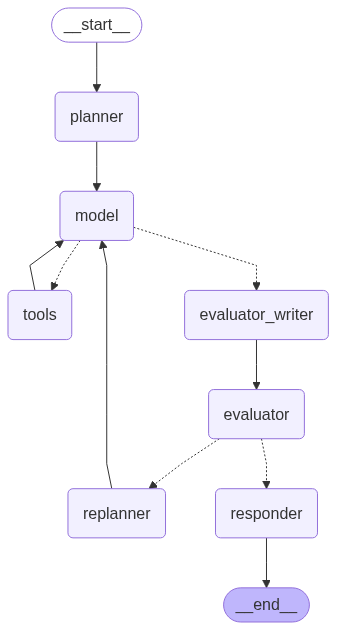

In [12]:
Image(graph.get_graph().draw_mermaid_png())


In [13]:
# No more model_dump() needed!
config = {"configurable": {"thread_id": "fresh_math_session"}}

# Pass the TypedDict directly to LangGraph
for chunk in graph.stream(initial_state, config=config, stream_mode="updates"):
    log_step(chunk)

[PLANNER] PLANNER → Here’s a step-by-step plan to maximize profit for Sarah's school fundraiser while staying within the $500 budget:

1. **Define Variables**: 
   - Let \( x \) be the number of cupcakes sold.
   - Let \( y \) be the number of T-shirts sold.
   - Let \( z \) be the number of buttons sold.

2. **Set Up the Profit Function**: 
   - Calculate the profit for each item:
     - Profit from cupcakes: \( 5x - 2x = 3x \)
     - Profit from T-shirts: \( 15y - 8y = 7y \)
     - Profit from buttons: \( 2z - 0.5z = 1.5z \)
   - Total profit function: \( P = 3x + 7y + 1.5z \)

3. **Set Up the Budget Constraint**: 
   - Total cost must not exceed $500 after accounting for permits and insurance:
     - Total cost: \( 2x + 8y + 0.5z + 75 \leq 500 \)
     - Simplified: \( 2x + 8y + 0.5z \leq 425 \)

4. **Set Up the Constraints for Each Item**: 
   - \( 0 \leq x \leq 50 \) (max cupcakes)
   - \( 0 \leq y \leq 30 \) (max T-shirts)
   - \( 0 \leq z \leq 100 \) (max buttons)

5. **Formulate

In [14]:
graph.get_state(config=config).values['messages'][-2]

AIMessage(content="outcome='GOOD' reasoning='The solution correctly identifies the optimal combination of items that maximizes profit while adhering to the budget and constraints. The calculations for costs and profits are accurate, and the chosen quantities fit within the specified limits.'", additional_kwargs={}, response_metadata={}, id='153584e1-7a11-4c78-a8c5-941db2dec1b6')

In [15]:
res = json.loads(graph.get_state(config=config).values["final_answer"])

In [16]:
check_solutions(res)

cost: 300.0 (computed 225)
profit: 275.0


In [17]:
res_llm = json.loads(llm_no_tools.with_structured_output(SimpleResponse).invoke([SystemMessage(content="Provide the answer to the math problem: " + problem)]).model_dump_json())

In [18]:
check_solutions(res_llm)

cost: 465.0 (computed 500)
profit: 510.0


In [19]:
# correct cost, correct profict
100 + 240 + 50, 50 * 3 + 30 * 7 + 100 * 1.5

(390, 510.0)

## Problem requirering optimisation

In [20]:
graph = get_math_graph()

problem = """
Sarah is organizing a school fundraiser with a $500 budget. She needs to:
- Buy items to sell (profit margin varies)  
- Pay for permits and insurance ($75 fixed)

Constraints:
- Cupcakes: $2 cost, $5 sell price, max 70 units
- T-shirts: $8 cost, $15 sell price, max 45 units  
- Buttons: $0.50 cost, $2 sell price, max 200 units

Maximize profit while staying within budget.

"""

# Create initial state using TypedDict (no more Pydantic!)
initial_state: MathProblemState = {
    "messages": [HumanMessage(content=f"Solve this step by step: {problem}")],
    "problem": problem,
    "steps": [],
    "current_step": 0,
    "calculations": [],
    "final_answer": None
}

In [21]:
graph.get_state(config=config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'fresh_math_session'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [22]:
# No more model_dump() needed!
config = {"configurable": {"thread_id": "fresh_math_session_complex"}}

# Pass the TypedDict directly to LangGraph
for chunk in graph.stream(initial_state, config=config, stream_mode="updates"):
    log_step(chunk)

[PLANNER] PLANNER → Here’s a step-by-step plan to maximize profit for Sarah's school fundraiser while staying within the $500 budget:

1. **Define Variables**: 
   - Let \( x \) be the number of cupcakes sold.
   - Let \( y \) be the number of T-shirts sold.
   - Let \( z \) be the number of buttons sold.

2. **Set Up the Cost Equation**: 
   - The total cost equation will be: 
     \[
     \text{Total Cost} = 2x + 8y + 0.5z + 75
     \]
   - This must be less than or equal to $500.

3. **Set Up the Profit Equation**: 
   - The profit equation will be:
     \[
     \text{Total Profit} = (5x - 2x) + (15y - 8y) + (2z - 0.5z) = 3x + 7y + 1.5z
     \]

4. **Define Constraints**: 
   - \( x \leq 70 \) (max cupcakes)
   - \( y \leq 45 \) (max T-shirts)
   - \( z \leq 200 \) (max buttons)
   - \( 2x + 8y + 0.5z + 75 \leq 500 \)

5. **Simplify the Budget Constraint**: 
   - Rearrange the budget constraint to isolate the variable costs:
     \[
     2x + 8y + 0.5z \leq 425
     \]

6. **Use a L

In [23]:
res_agent = json.loads(graph.get_state(config=config).values["final_answer"])

In [24]:
check_solutions(res_agent)

cost: 500.0 (computed 500)
profit: 555.0


In [25]:
res_llm = json.loads(llm_no_tools.with_structured_output(SimpleResponse).invoke([SystemMessage(content="Provide the answer to the math problem: " + problem)]).model_dump_json())

In [26]:
check_solutions(res_llm)

cost: 575.0 (computed 500)
profit: 525.0
